1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Fill a numpy array, x, of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
N=200
x=np.random.normal(loc=5.5,scale=0.5,size=N)

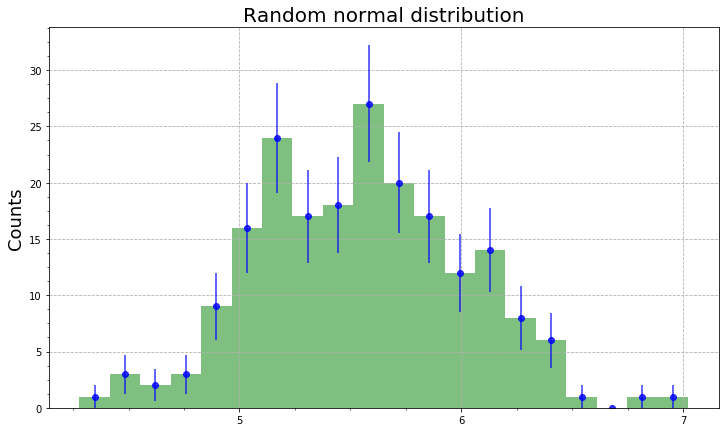

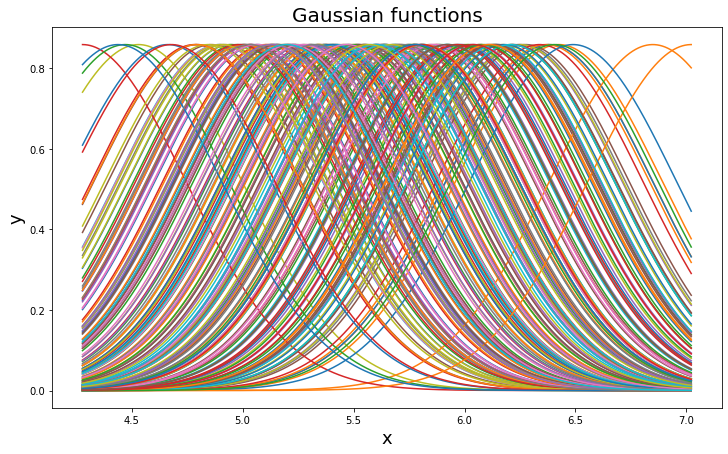

In [3]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_ylabel('Counts', size=18)
ax.set_title('Random normal distribution',size=20)
ax.grid(linestyle='--')
num_bins=20
histogram,bins,_=ax.hist(x,bins=num_bins,range=(x.min(),x.max()),alpha=0.5,histtype='stepfilled',color='green')
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.errorbar(bin_centers, histogram, yerr=np.sqrt(histogram), fmt='bo',alpha=0.8)
import scipy.stats
import scipy
fig,ax=plt.subplots(figsize=(12,7))
ax.set_xlabel('x',size=18)
ax.set_ylabel('y', size=18)
ax.set_title('Gaussian functions',size=20)
gauss=np.array([scipy.stats.norm(xi,np.std(x)) for xi in x])
gauss_pdf=[]
domain=np.linspace(np.min(bins),np.max(bins),10000)
for item in gauss:
    gauss_pdf.append(item.pdf(domain))
    ax.plot(domain,item.pdf(domain))
plt.show()

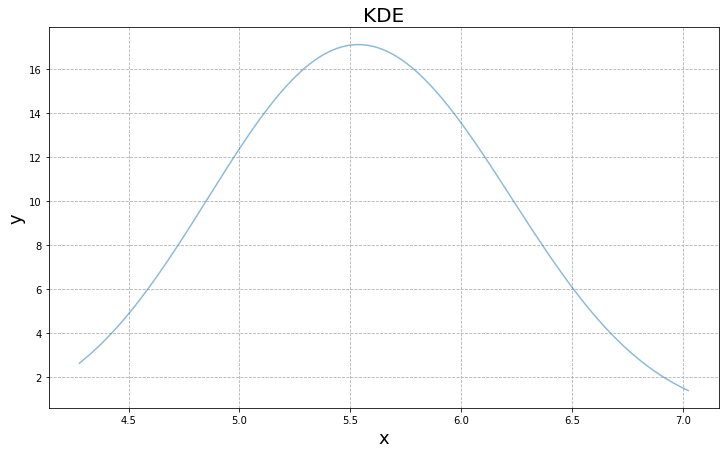

In [4]:
density=np.sum(gauss_pdf,axis=0)
fig,ax=plt.subplots(figsize=(12,7))
ax.set_title('KDE',size=20)
ax.set_xlabel('x',size=18)
ax.set_ylabel('y', size=18)
ax.grid(linestyle='--')
integral0=scipy.integrate.trapz(histogram,bin_centers)
integral1 = scipy.integrate.trapz(density, domain)
ax.plot(domain, density*(integral0/integral1), alpha=0.5)
plt.show()

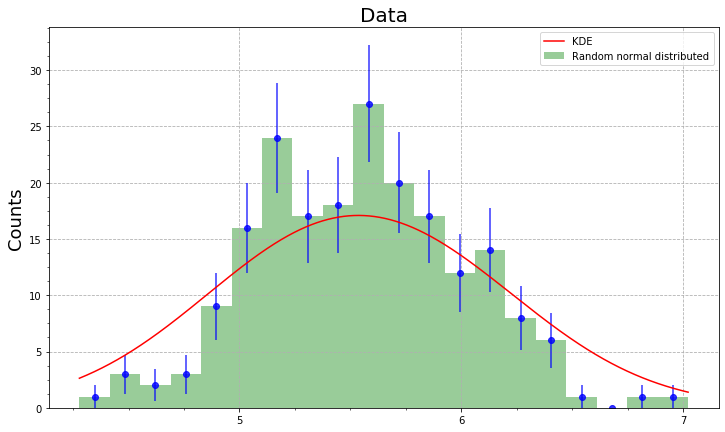

In [5]:
fig,ax= plt.subplots(figsize=(12, 7))
ax.set_title('Data',size=20)
ax.set_ylabel('Counts',size=18)
ax.grid(linestyle='--')
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.plot(domain, density*(integral0/integral1), label='KDE',color='red')
ax.errorbar(bin_centers, histogram, yerr=np.sqrt(histogram), fmt='bo',alpha=0.8)
ax.hist(x,bins=num_bins,range=(x.min(),x.max()),alpha=0.4,histtype='stepfilled',color='green',label='Random normal distributed')
ax.legend()
plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [ ]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [6]:
import pandas as pd

In [7]:
def dataset(dimension):

    mean1=[7.5,2.5]
    std1=3
    mean2=[2.5,7.5]
    std2=4
    data_1=np.random.multivariate_normal(mean1,[[std1,0],[0,std1]],int(dimension))
    df1=pd.DataFrame(
        { 'Set':np.array(['one' for i in range(dimension)]),
          'x': np.random.multivariate_normal(mean1,[[std1,0],[0,std1]],int(dimension))[:,0],
          'y': np.random.multivariate_normal(mean1,[[std1,0],[0,std1]],int(dimension))[:,1]
        })
    df2=pd.DataFrame(
        { 'Set':np.array(['two' for i in range(dimension)]),
          'x': np.random.multivariate_normal(mean2,[[std2,0],[0,std2]],int(dimension))[:,0],
          'y': np.random.multivariate_normal(mean2,[[std2,0],[0,std2]],int(dimension))[:,1],
        })
    data=pd.concat([df1,df2],ignore_index=True)
    return(data)

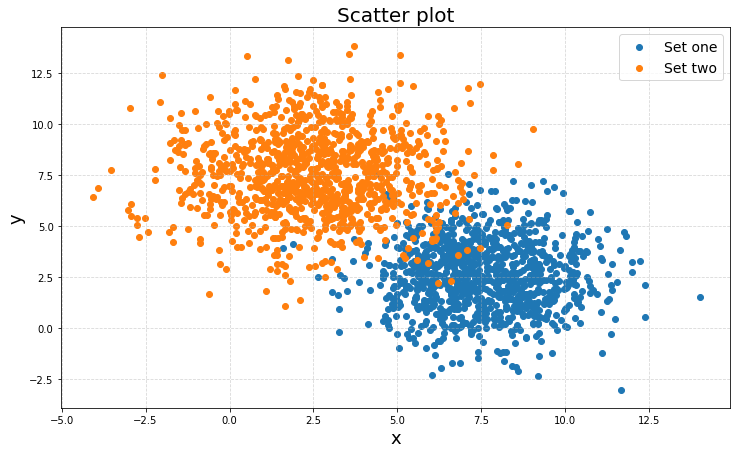

In [8]:
data=dataset(1000)
fig,ax=plt.subplots(figsize=(12,7))
scatter = ax.scatter(x=data[data['Set']=='one']['x'], y=data[data['Set']=='one']['y'],label='Set one')
scatter = ax.scatter(x=data[data['Set']=='two']['x'], y=data[data['Set']=='two']['y'],label='Set two')
ax.legend(loc='best', prop={'size': 14})
ax.grid(linestyle='--',alpha=0.5)
ax.set_title('Scatter plot',size=20)
ax.set_ylabel('y',size=18)
ax.set_xlabel('x',size=18)
plt.show()

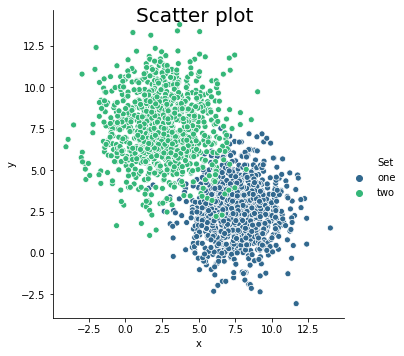

In [9]:
import seaborn as sns
scatter=sns.relplot(x='x', y='y', hue='Set', data=data,palette='viridis')
scatter.fig.suptitle('Scatter plot',fontsize=20)
plt.show()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [10]:
!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2020-12-23 10:29:57--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [following]
--2020-12-23 10:29:58--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce395f21829f69436338a0be6de.dl.dropboxusercontent.com/cd/0/inline/BFmrFHIMiKANcwYTH61IR7pR3ACZZCK1PLEt5-alqI3qh_4jmMIXuqNGiz8hPvcnC-28IYUaa0AYag6UocgCf0KsNV1M9IUIYS38FSB3J2JMrQ/file# [following]
--2020-12-23 10:29:58--  https://uce395f21829f69436338a0be6de.dl.dropboxusercontent.com/cd/0/inline/BFmrFHIMiKANcwYTH61IR7pR3ACZZCK1PLEt5-alqI3qh_4jmMIXuqNGiz8hPvcnC-28IYUaa0AYag6UocgCf0KsNV1M9IUIYS38FSB3J2JMrQ/file
Resolving uce395f21829f6943

In [11]:
residual=np.load('residuals_261.npy',allow_pickle=True)
df=pd.DataFrame(residual.item())
clear=np.abs(df['residuals'])<2
df=df[clear]
slope,intercept,rvalue,_,_=scipy.stats.linregress(df['distances'],df['residuals'])
print('Linear regression result:\nslope:{}\nintercept:{}\nrvalue:{}'.format(slope,intercept,rvalue))

Linear regression result:
slope:0.0032597701220305813
intercept:-0.1543281676306947
rvalue:0.04340351052255907


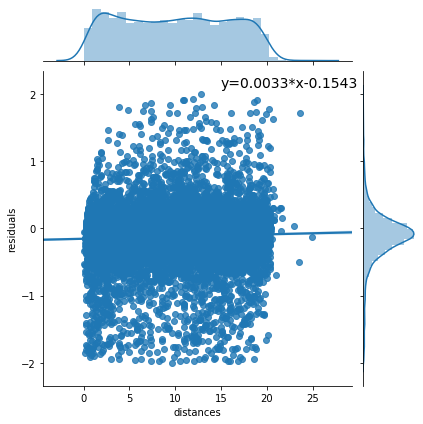

In [12]:
graph=sns.jointplot('distances', 'residuals', data=df, kind="reg")
regression='y=%.4f*x%.4f' %(slope,intercept)
results_canvas=plt.text(15,2.1,regression,fontsize=14)

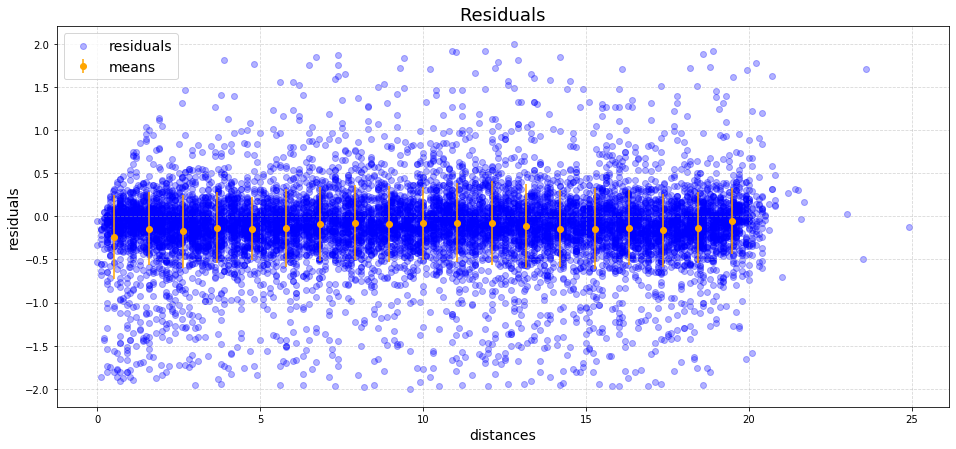

In [13]:
bins=np.linspace(0,20,20,endpoint=True)
x=0.5*(bins[:-1]+bins[1:]) 
y=[]
erry=[]
for i in range(len(x)):
    if i!=len(bin_centers-1):
        binned=df[(df['distances']<bins[i+1]) & (df['distances']>=bins[i])]
        y.append(binned['residuals'].mean())
        erry.append(binned['residuals'].std())
    else:
        binned=df[(df['distances']<bins[i+1]) & (df['distances']>=bins[i])]
        y.append(binned['residuals'].mean())
        erry.append(binned['residuals'].std())
y=np.array(y)
erry=np.array(erry)
fig,ax=plt.subplots(figsize=(16,7))
scatter=ax.scatter(df['distances'],df['residuals'],color='blue',alpha=0.3,label='residuals')
errorbars=ax.errorbar(x,y,yerr=erry,fmt='o',color='orange',label='means')
ax.legend(loc='best',prop={'size': 14})
ax.set_xlabel('distances',size=14)
ax.set_ylabel('residuals',size=14)
ax.set_title('Residuals',size=18)
ax.grid(linestyle='--',alpha=0.5)
plt.show()